# Lecture 7 Matching Analysis - TaskRabbit

## 1. Introduction
<font size=4 face='Times Roman'> TaskRabbit has been building a marketplace that matches freelance labor with local demand. Therefore, one of the key problems we need to solve is how to **make better matches**? In other words, what makes a client choose a tasker? And how could we help a tasker to get hired?<br>
<br>
Intuitively, when we present a ‘recommendation’ consisting of 15 taskers, the client would make the decision based on the **ranks of hourly rate and number of completed tasks** in the ‘recommendation’ list (rate rank & task rank for short), instead of the absolute values. Therefore, we mainly focused on recommending the **best rate rank and corresponding hourly rate** to a tasker based on his/her **task rank**, and validating the recommendation using a **Logistic Regression** model

## 2. Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
raw_data = pd.read_csv('sample.csv')
raw_data.head()

FileNotFoundError: ignored

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
recommendation_id      30000 non-null object
created_at             30000 non-null object
tasker_id              30000 non-null int64
position               30000 non-null int64
hourly_rate            30000 non-null int64
num_completed_tasks    30000 non-null int64
hired                  30000 non-null int64
category               30000 non-null object
dtypes: int64(5), object(3)
memory usage: 1.8+ MB


In [ ]:
raw_data.describe()

,tasker_id,position,hourly_rate,num_completed_tasks,hired
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.011072e+09,7.873600,57.482533,221.235700,0.056833
std,2.501822e+06,4.319442,36.222860,279.801812,0.231528
min,1.006647e+09,1.000000,18.000000,0.000000,0.000000
25%,1.008955e+09,4.000000,38.000000,23.000000,0.000000
50%,1.010579e+09,8.000000,45.000000,114.000000,0.000000
75%,1.013444e+09,12.000000,60.000000,300.250000,0.000000
max,1.015020e+09,15.000000,290.000000,1406.000000,1.000000


* <font size=3>***No null values***
* <font size=3>***Hourly_rate ranges from 18 to 29, with a median of 45***
* <font size=3>***Number of completed tasks ranges from 0 to 1406, with a median of 114***

In [ ]:
hired = raw_data[['recommendation_id','hired']].groupby('recommendation_id').sum()
＃hired_0 = hired[hired['hired']==0].reset_index()
len(hired_0)/len(set(raw_data['recommendation_id']))

0.1880952380952381

In [ ]:
data = raw_data[-raw_data['recommendation_id'].isin(hired_0['recommendation_id'])]
data = data[['recommendation_id','position','hourly_rate','num_completed_tasks','hired','category']]

* <font size=3>***Around 19% of the recommendations yielded no hire***
* <font size=3>***Since we try to analyze how a client choose a tasker in a recommendation list, we could dig into position, hourly rate, number of completed tasks, and the recommendations with hire for the time being***

## 3. EDA

### 3.1 Position

Text(0.5,1,'Fig.1 Possibility of Getting Hired by Position')

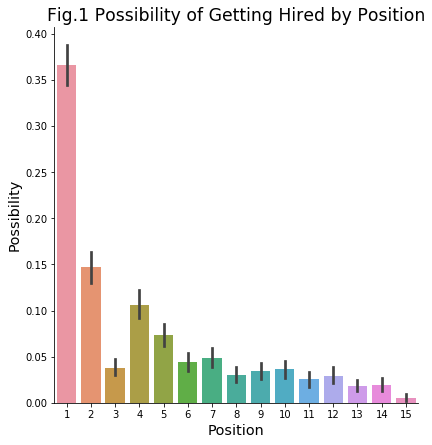

In [ ]:
sns.factorplot(data=data, x='position',y ='hired', kind='bar', size=6)
plt.xlabel('Position', fontsize='x-large')
plt.ylabel('Possibility', fontsize='x-large')
plt.title('Fig.1 Possibility of Getting Hired by Position', fontsize='xx-large')

* <font size=3>***Not surprisingly, taskers' positions influence clients' decisions. In particular, taskers in position 1 has remarkably higher chance of getting hired, followed by position 2, 4 and 5 ***
* <font size=3>***Similar to Google's competitive ranking, we could charge higher commission fee for placing a tasker at better positions***  

### 3.2 Hourly Rate & Num of Completed Tasks

### 3.2.1 Feature Engineering

Text(0.5,1,'Fig.3 Distribution of Number of Completed Tasks')

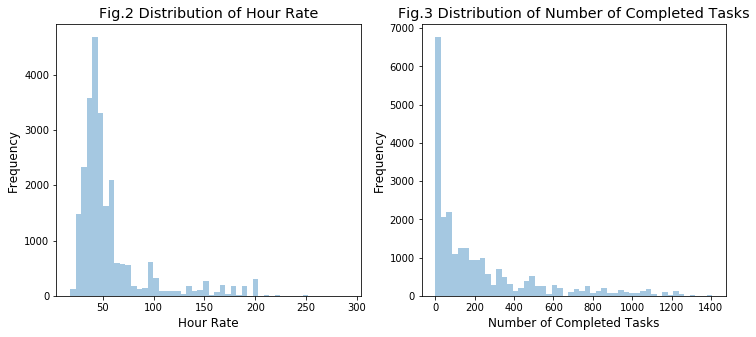

In [ ]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
sns.distplot(data['hourly_rate'], kde=False)
plt.xlabel('Hour Rate', fontsize='large')
plt.ylabel('Frequency', fontsize='large')
plt.title('Fig.2 Distribution of Hour Rate', fontsize='x-large')

ax2 = fig.add_subplot(122)
sns.distplot(data['num_completed_tasks'], kde=False)
plt.xlabel('Number of Completed Tasks', fontsize='large')
plt.ylabel('Frequency', fontsize='large')
plt.title('Fig.3 Distribution of Number of Completed Tasks', fontsize='x-large')

* <font size=3>***The distributions are extremely right-skewed, not appropriate for further analysis and model building*** 
* <font size=3>***We could analyze the ranks in each recommendation instead, which makes more sense in reality and for modeling***

In [ ]:
data['task_rank']=data.groupby('recommendation_id')['num_completed_tasks'].rank('first',ascending=False)
data['rate_rank']=data.groupby('recommendation_id')['hourly_rate'].rank('first',ascending=False)

Text(0.5,1,'Fig.5 Possibility of Getting Hired by Rate Rank')

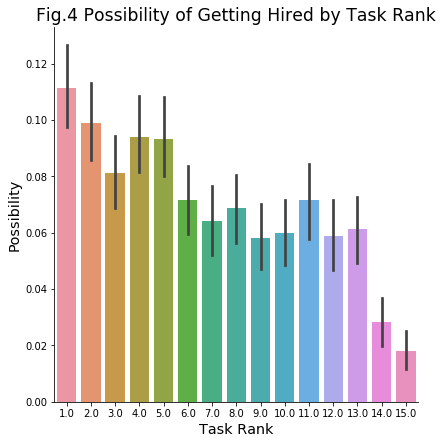

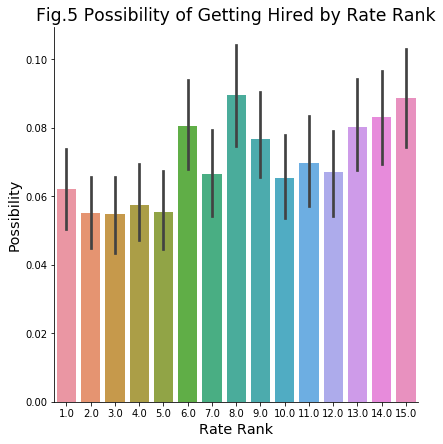

In [ ]:
sns.factorplot(data=data, x='task_rank',y ='hired', kind='bar', size=6)
plt.xlabel('Task Rank', fontsize='x-large')
plt.ylabel('Possibility', fontsize='x-large')
plt.title('Fig.4 Possibility of Getting Hired by Task Rank', fontsize='xx-large')

sns.factorplot(data=data, x='rate_rank',y ='hired', kind='bar', size=6)
plt.xlabel('Rate Rank', fontsize='x-large')
plt.ylabel('Possibility', fontsize='x-large')
plt.title('Fig.5 Possibility of Getting Hired by Rate Rank', fontsize='xx-large')

* <font size=3>***Apparently, Task Rank and Rate Rank have great impact on the possibility of getting hired***
* <font size=3>***To avoid overfitting of the model, we could group the ranks into High, Medium, and Low groups according to the possibilities***

In [ ]:
def task(x):
  if x <=5:
    return 'high'
  elif x<=13:
    return 'medium'
  else:
    return 'low'

def rate(x):
  if x <=5:
    return 'high'
  elif (x==7)|(x==10)|(x==11)|(x==12):
    return 'medium'
  else:
    return 'low'

data['task_rank2'] = data['task_rank'].apply(task)
data['rate_rank2'] = data['rate_rank'].apply(rate)

Text(0.5,1,'Fig.7 Possibility of Getting Hired by Rate Rank')

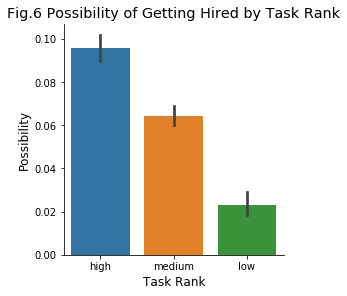

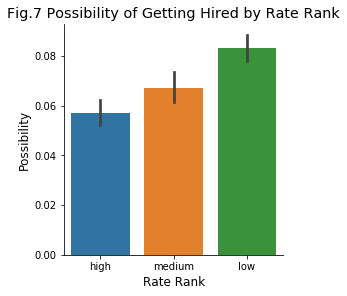

In [ ]:
sns.factorplot(data=data, x='task_rank2',y ='hired', kind='bar',size=4)
plt.xlabel('Task Rank', fontsize='large')
plt.ylabel('Possibility', fontsize='large')
plt.title('Fig.6 Possibility of Getting Hired by Task Rank', fontsize='x-large')

sns.factorplot(data=data, x='rate_rank2',y ='hired', kind='bar',size=4)
plt.xlabel('Rate Rank', fontsize='large')
plt.ylabel('Possibility', fontsize='large')
plt.title('Fig.7 Possibility of Getting Hired by Rate Rank', fontsize='x-large')

### 3.2.2  Combination of Task Rank & Rate Rank

Text(0.5,1,'Fig.8 Frequency of Rank Combinations')

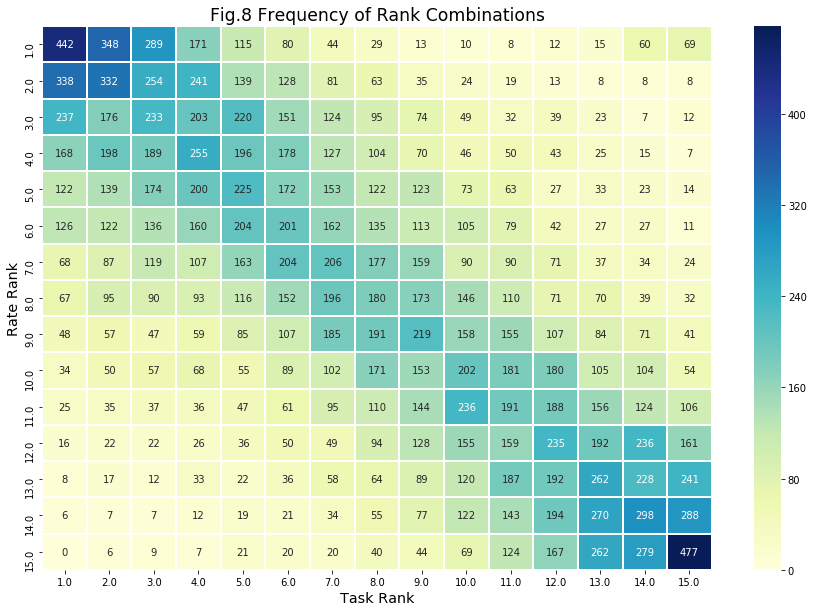

In [ ]:
table1 = pd.pivot_table(data=data, columns='task_rank', index='rate_rank', aggfunc=len, values='recommendation_id',fill_value=0)
fig = plt.figure(figsize=(15,10))
sns.heatmap(table1,cmap='YlGnBu', linewidths=1, annot=True,fmt='g')
plt.xlabel('Task Rank', fontsize='x-large')
plt.ylabel('Rate Rank', fontsize='x-large')
plt.title('Fig.8 Frequency of Rank Combinations', fontsize='xx-large')

* <font size=3>***Overall, lowest rate with least experience, highest rate with most experience are two most frequent cases***

Text(0.5,1,'Fig.9 Possibility of Getting Hired across Rank Combinations')

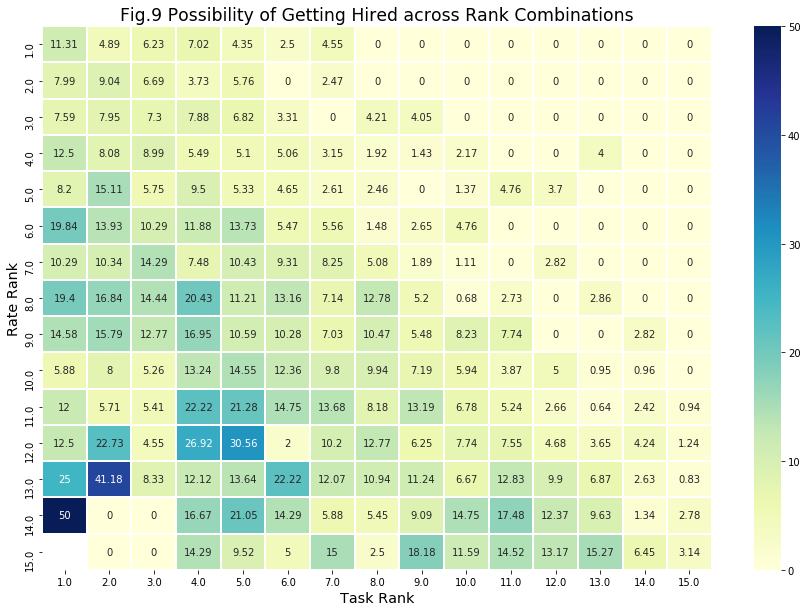

In [ ]:
table2 = pd.pivot_table(data=data, columns='task_rank', index='rate_rank', aggfunc=lambda x: np.round(np.mean(x)*100,2), values='hired')

fig = plt.figure(figsize=(15,10))
sns.heatmap(table2,cmap='YlGnBu', linewidths=1, annot=True,fmt='g')
plt.xlabel('Task Rank', fontsize='x-large')
plt.ylabel('Rate Rank', fontsize='x-large')
plt.title('Fig.9 Possibility of Getting Hired across Rank Combinations', fontsize='xx-large')

* <font size=3>***Overal, more experienced taskers with lower rates have higher possibilities of getting hired***

### 3.2.3 Recommendations

In [ ]:
def recommend(df):
    table1 = pd.pivot_table(data=df, columns='task_rank', index='rate_rank', aggfunc=len, values='recommendation_id',fill_value=0)
    table2 = pd.pivot_table(data=df, columns='task_rank', index='rate_rank', aggfunc=np.mean, values='hired')
    table = table2[table1>80].fillna(0)
    rate = []
    optimal = []
    median_value = []
    for i in table.columns:
        optimal.append(np.round(100*max(table[i]),2))
        rate.append(np.argmax(table[i]))
        median_value.append(df[df['rate_rank']==np.argmax(table[i])]['hourly_rate'].median())
    optimal_selection = pd.DataFrame({'Task_Rank': np.arange(1,16,1),'Rate_Rank':rate,'Hourly_Rate': np.round(median_value,0),'Possibility':optimal}, index=np.arange(1,16,1)).set_index('Task_Rank')
    return optimal_selection.sort_values(by='Possibility',ascending=False).reset_index()[:5]

* <font size=3>***For each category, search for the optimal combination of task rank and rate rank, which has high possibilities of getting hired***
* <font size=3>***Exclude combinations with frequency less than 100 to ensure credibility of the results***

In [ ]:
data_FA = data[data['category']=='Furniture Assembly']
data_MT = data[data['category']=='Mounting']
data_MH = data[data['category']=='Moving Help']

#### Table 1

In [ ]:
recommend(data_FA)

,Task_Rank,Rate_Rank,Hourly_Rate,Possibility
0,5,6.0,40.0,18.09
1,1,1.0,48.0,16.56
2,13,15.0,26.0,14.02
3,3,3.0,44.0,13.86
4,2,1.0,48.0,12.40


* <font size=3>***For Furniture Assembly, if the tasker is highly experienced and ranks top 5 in number of completed tasks, we could recommend top 6 rate ranks, which are around 44 or 48 according to historical median values***

#### Table 2

In [ ]:
recommend(data_MT)

,Task_Rank,Rate_Rank,Hourly_Rate,Possibility
0,1,1.0,60.0,10.48
1,2,4.0,59.0,9.76
2,5,3.0,60.0,8.64
3,4,2.0,60.0,8.14
4,14,15.0,34.0,7.55


* <font size=3>***For Mounting, if the tasker is highly experienced and ranks top 5 in number of completed tasks, we could recommend top 4 rate ranks, which are around 60 according to historical median values***

#### Table 3

In [ ]:
recommend(data_MH)

,Task_Rank,Rate_Rank,Hourly_Rate,Possibility
0,13,14.0,38.0,15.12
1,1,2.0,80.0,8.49
2,15,15.0,34.0,7.83
3,14,12.0,44.0,6.02
4,3,1.0,85.0,3.48


* <font size=3>***For Moving Help, if the tasker is least experienced and ranks least 3 in number of completed tasks, we could recommend lower rate ranks, which are around 34 or 44 according to historical median***

## 4. Data Modeling

### 4.1 Data Preparation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

data_new = pd.get_dummies(data[['category','task_rank2','rate_rank2']], drop_first=False)

X = data_new.as_matrix()
y = data['hired'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, stratify=y, train_size=0.8)

### 4.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(class_weight='balanced')

* <font size=3>***Logistic regression has great interpretability and works good for binary classification problems***
* <font size=3>***Since only 1 in 15 in each recommendation was hired, the dataset is very imbalanced and we need to adjust the class_weight to ensure better performance***

### 4.2.1 GridSearch & Parameter Tuning





In [ ]:
C = np.arange(0.001,0.01,0.001)
penalty = ['l1','l2']

param_grid = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(lgr, param_grid, scoring='recall', cv=5)
grid_result = grid_search.fit(X_train, y_train)

result_lgr = pd.DataFrame(grid_result.cv_results_)
result_lgr.sort_values(by='mean_test_score', ascending=False)[:4]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.014114,0.001322,0.001333,0.000150,0.004,l1,"{'C': 0.004, 'penalty': 'l1'}",0.468864,0.402930,0.769231,...,0.622514,0.154550,1,0.464711,0.481210,0.751604,0.763520,0.756410,0.643491,0.139387
8,0.013693,0.000690,0.001268,0.000014,0.005,l1,"{'C': 0.005, 'penalty': 'l1'}",0.754579,0.402930,0.479853,...,0.621782,0.149722,2,0.755270,0.481210,0.526123,0.763520,0.756410,0.656507,0.125631
10,0.013186,0.000488,0.001268,0.000025,0.006,l1,"{'C': 0.006, 'penalty': 'l1'}",0.754579,0.402930,0.479853,...,0.621782,0.149722,2,0.755270,0.481210,0.526123,0.763520,0.756410,0.656507,0.125631
1,0.010853,0.001160,0.001137,0.000015,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.754579,0.494505,0.479853,...,0.598230,0.106233,4,0.755270,0.549038,0.526123,0.715857,0.608974,0.631052,0.090384


In [ ]:
best_lgr = grid_search.best_estimator_
y_pred = best_lgr.predict(X_test)
print(recall_score(y_test,y_pred))

0.7859237536656891


* <font size=3>***Use GridSearch for parameter tuning on penalty and C in regularization***
* <font size=3>***We are more interested in the taskers who get hired, so recall score is an appropriate metric in cross validation and measuring generalization ability***
* <font size=3>***The bset model has a recall score of 0.79 on testing dataset, which could be improved by adjusting the threshold probability and adding other impactful factors as independent variables***    

### 4.2.2 Result Interpretation



#### Table 4

In [ ]:
Coeffient = best_lgr.coef_.flatten()
pd.DataFrame({'Coeffient':Coeffient}, index=data_new.columns).sort_values(by='Coeffient', ascending=False)

,Coeffient
task_rank2_high,0.421142
rate_rank2_low,0.031162
category_Furniture Assembly,0.000000
category_Mounting,0.000000
category_Moving Help,0.000000
task_rank2_medium,0.000000
rate_rank2_medium,0.000000
rate_rank2_high,-0.389550
task_rank2_low,-0.498484


* <font size=3>***Clients care more about task rank than rate rank. Clients care more about task rank than rate rank***
* <font size=3>***high rank in number of completed tasks remarkably increases the possibility of getting hired, while low rank decreases the possibility sigificantly***
* <font size=3>***Category does not influence clients' decisions***

### 4.2.3 Validate Recommendations

In [ ]:
data_FA2 = recommend(data_FA)
FA_test = pd.DataFrame({'category':'Furniture Assembly','task_rank2':data_FA2['Task_Rank'],'rate_rank2':data_FA2['Rate_Rank']})
FA_test['task_rank2'] = FA_test['task_rank2'].apply(task)
FA_test['rate_rank2'] = FA_test['rate_rank2'].apply(rate)

data_new = pd.get_dummies(FA_test[['category','task_rank2','rate_rank2']], drop_first=False)
data_new['FA']=0
data_new['MH']=0
data_new= data_new.iloc[:,[0,-2,-1,1,2,3,4,5,6]]
data_new.head()
X = data_new.as_matrix()
y_pred = best_lgr.predict(X)
pd.DataFrame({'Task Rank':data_FA2['Task_Rank'],'Rate Rank':data_FA2['Rate_Rank'],
              'Hourly Rate':data_FA2['Hourly_Rate'],'Possibility':data_FA2['Possibility'],
              'Predicted Hired':best_lgr.predict(X)}).set_index('Task Rank')

,Rate Rank,Hourly Rate,Possibility,Predicted Hired
Task Rank,,,,
5,6.0,40.0,18.09,1
1,1.0,48.0,16.56,1
13,15.0,26.0,14.02,0
3,3.0,44.0,13.86,1
2,1.0,48.0,12.40,1


* <font size=3>***For Furniture Assembly, 4 out of 5 recommendations we make are predicted to get hired***

In [ ]:
data_MT2 = recommend(data_MT)
MT_test = pd.DataFrame({'category':'Mounting','task_rank2':data_MT2['Task_Rank'],'rate_rank2':data_MT2['Rate_Rank']})
MT_test['task_rank2'] = MT_test['task_rank2'].apply(task)
MT_test['rate_rank2'] = MT_test['rate_rank2'].apply(rate)

data_new = pd.get_dummies(MT_test[['category','task_rank2','rate_rank2']], drop_first=False)
data_new['FA']=0
data_new['MH']=0
data_new= data_new.iloc[:,[-2,0,-1,1,2,3,4,5,6]]
data_new.head()
X = data_new.as_matrix()
y_pred = best_lgr.predict(X)
pd.DataFrame({'Task Rank':data_MT2['Task_Rank'],'Rate Rank':data_MT2['Rate_Rank'],
              'Hourly Rate':data_MT2['Hourly_Rate'],'Possibility':data_MT2['Possibility'],
              'Predicted Hired':best_lgr.predict(X)}).set_index('Task Rank')

,Rate Rank,Hourly Rate,Possibility,Predicted Hired
Task Rank,,,,
1,1.0,60.0,10.48,1
2,4.0,59.0,9.76,1
5,3.0,60.0,8.64,1
4,2.0,60.0,8.14,1
14,15.0,34.0,7.55,0


* <font size=3>***For Mounting, 4 out of 5 recommendations we make are predicted to get hired***

In [ ]:
data_MH2 = recommend(data_MH)
MH_test = pd.DataFrame({'category':'Moving Help','task_rank2':data_MH2['Task_Rank'],'rate_rank2':data_MH2['Rate_Rank']})
MH_test['task_rank2'] = MH_test['task_rank2'].apply(task)
MH_test['rate_rank2'] = MH_test['rate_rank2'].apply(rate)

data_new = pd.get_dummies(MH_test[['category','task_rank2','rate_rank2']], drop_first=False)
data_new['FA']=0
data_new['MT']=0
data_new= data_new.iloc[:,[-2,-1,0,1,2,3,4,5,6]]
data_new.head()
X = data_new.as_matrix()
y_pred = best_lgr.predict(X)
pd.DataFrame({'Task Rank':data_MH2['Task_Rank'],'Rate Rank':data_MH2['Rate_Rank'],
              'Hourly Rate':data_MH2['Hourly_Rate'],'Possibility':data_MH2['Possibility'],
              'Predicted Hired':best_lgr.predict(X)}).set_index('Task Rank')

,Rate Rank,Hourly Rate,Possibility,Predicted Hired
Task Rank,,,,
13,14.0,38.0,15.12,1
1,2.0,80.0,8.49,1
15,15.0,34.0,7.83,0
14,12.0,44.0,6.02,0
3,1.0,85.0,3.48,1


* <font size=3>***For Moving Help, 3 out of 5 recommendations we make are predicted to get hired***